<h1><center>Sample design - Stress/Strain anisotropy tester</center></h1>

### Parameters for file to test

This is the **only section** you must edit !

For the constitutive model, you may choose between :
- '1-tanhplastic'
- '2-perfectplasticity'


In [1]:
# list available samples
from os import listdir
meshpath = './output_files/'
mesh_list = [x for x in listdir(meshpath) if x.endswith('.xdmf')]

mesh_list

['2hole.xdmf',
 '2notch.xdmf',
 'AG03.xdmf',
 'example_2fold.xdmf',
 'example_3fold.xdmf',
 'example_network_2fold.xdmf',
 'example_network_3fold.xdmf',
 'HarmH27.xdmf',
 'rand_network_2fold.xdmf',
 'rand_network_3fold.xdmf',
 'test_array_circle.xdmf',
 'test_array_ellipse.xdmf',
 'test_clover.xdmf',
 'test_clover_rand.xdmf',
 'test_complex-harmonic-holes.xdmf',
 'test_dumbell.xdmf',
 'test_dumbell_45.xdmf',
 'test_dumbell_BF3.xdmf',
 'test_genmesh_network_2fold.xdmf',
 'test_genmesh_network_3fold.xdmf',
 'test_loop_array_2fold.xdmf',
 'test_loop_array_3fold.xdmf',
 'test_network_2fold.xdmf',
 'test_network_3fold.xdmf',
 'test_NPR.xdmf',
 'test_NPR_3.xdmf',
 'test_NPR_rounded.xdmf',
 'test_NPR_rounded_45.xdmf',
 'test_NPR_rounded_90.xdmf',
 'test_NPR_rounded_h.xdmf',
 'test_NPR_rounded_rand.xdmf',
 'test_NPR_rounded_swivel.xdmf',
 'test_NPR_rounded_v.xdmf',
 'test_simplehole_discA1.xdmf',
 'test_simplehole_discA2.xdmf',
 'test_simplehole_discB1.xdmf',
 'test_simplehole_ellipseA12.xdmf'

In [2]:
mesh_list = [
 '2hole.xdmf',
 '2notch.xdmf',
 'test_array_circle.xdmf',   
 'test_array_ellipse.xdmf',
 'test_clover.xdmf',
 'test_dumbell.xdmf',
 'test_dumbell_45.xdmf',
 'test_dumbell_BF3.xdmf',
#  'test_clover_rand.xdmf',
#  'test_loop_array_2fold.xdmf',
#  'test_loop_array_3fold.xdmf',
#  'test_NPR.xdmf',
 'test_NPR_rounded.xdmf',
 'test_NPR_rounded_45.xdmf',
#  'test_NPR_rounded_90.xdmf',
#  'test_NPR_rounded_rand.xdmf',
#  'test_NPR_rounded_swivel.xdmf',
#  'test_NPR_rounded_h.xdmf',
#  'test_NPR_rounded_v.xdmf',
 'test_simplehole_discA1.xdmf',
 'test_simplehole_ellipseA12.xdmf',
 'test_simplehole_rectangleA12.xdmf',
 'test_simplehole_squareA1.xdmf',
 'test_simplehole_squareB1.xdmf',
 'test_withouthole.xdmf',
#  'example_2fold.xdmf',
#  'example_3fold.xdmf',
]

In [3]:
import re

mesh_list_simple = mesh_list.copy()
for i in range(len(mesh_list_simple)):
    mesh_list_simple[i] = re.sub('.xdmf','',mesh_list_simple[i])
    mesh_list_simple[i] = re.sub('test_','',mesh_list_simple[i])
#     mesh_list_simple[i] = re.sub('_',' ',mesh_list_simple[i])
    mesh_list_simple[i] = re.sub('simplehole_','',mesh_list_simple[i])
    mesh_list_simple[i] = re.sub('NPR','bowtie',mesh_list_simple[i])
    mesh_list_simple[i] = re.sub('_rounded','',mesh_list_simple[i])
    
mesh_list_simple

['2hole',
 '2notch',
 'array_circle',
 'array_ellipse',
 'clover',
 'dumbell',
 'dumbell_45',
 'dumbell_BF3',
 'bowtie',
 'bowtie_45',
 'discA1',
 'ellipseA12',
 'rectangleA12',
 'squareA1',
 'squareB1',
 'withouthole']

In [4]:
# from fenics import *
# from dolfin_adjoint import *
# import pygmsh_mesh_functions
# from pygmsh_mesh_functions import *
# import meshio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# For quality evaluation
from anisotropyv3 import GapScore
# from anisotropy_density import *

from scipy.io import loadmat

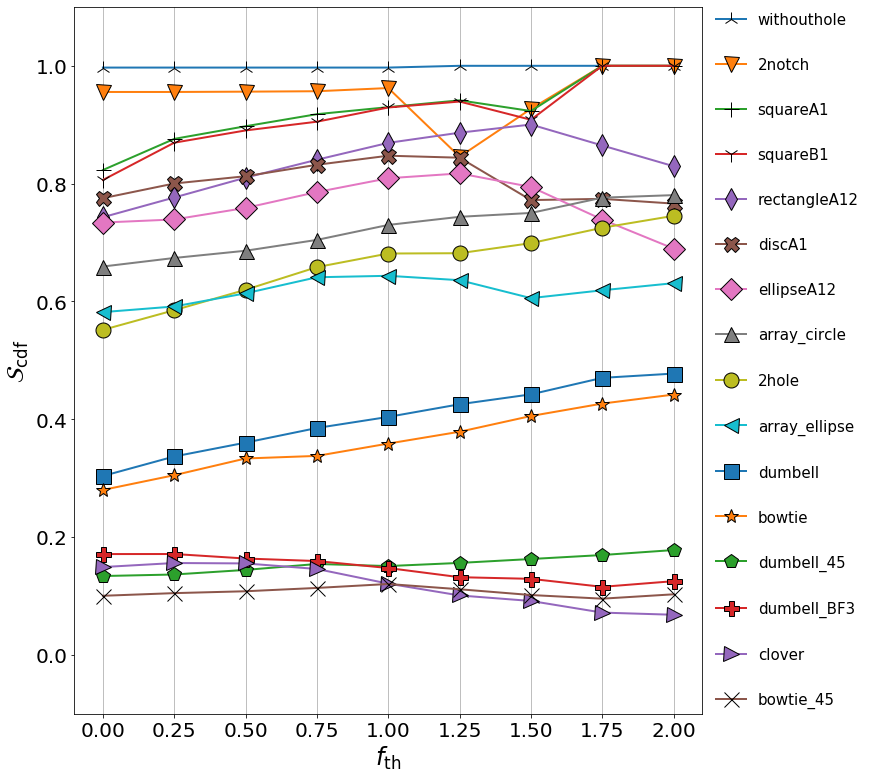

In [11]:
# Grid Gap score wrt threshold
from matplotlib.lines import Line2D
markers_list = ["o","v","^","<",">","s","p","P","*","x","X","D","d","+","1","2","3","4",0,1,2,3,4,5,6,7,8,9,10,11
]

fig = plt.figure(figsize=(15, 13))
ax = plt.subplot(1, 1, 1)
ax.set_xlim(-.1, 2.1)
ax.set_ylim(-.1, 1.1)
ax.set_xticks(np.array([0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00]))
# ax.set_yticks(np.array([-1, -0.5, 0, 0.5, 1]))
ax.set_xlabel(r'$f_{\rm{th}}$',fontsize=24)
ax.set_ylabel(r'$\mathcal{S}_{\rm{cdf}}$',fontsize=24)
ax.tick_params(which='both', labelsize=20)
# ax.ticklabel_format(scilimits=(0,0))
ax.xaxis.offsetText.set_fontsize(20)
ax.yaxis.offsetText.set_fontsize(20)
ax.grid(visible=True, which='major', axis='x')

scores = []
for i in range(len(mesh_list)):
    
    #### Meshfile ####
    meshfile = mesh_list[i]                    # with .xdmf

    # load data
    filename = './score/'+meshfile+'_score_grid.mat'
    Score_gap = loadmat(filename)['Score_gap']
    scores.append(Score_gap[0,4])

i_sort = np.argsort(scores)[::-1]  

lines = []
for im in range(len(mesh_list)):
    i = i_sort[im]
    #### Meshfile ####
    meshfile = mesh_list[i]                    # with .xdmf
    
    # load data
    filename = './score/'+meshfile+'_score_grid.mat'
    Score_gap = loadmat(filename)['Score_gap'][0]
    
    thresholds = [0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00]
    lines.append(ax.plot(thresholds,Score_gap, '-', 
                         marker=markers_list[i], markersize=15, markeredgecolor='k',
                         label=mesh_list_simple[i], linewidth=2))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width*0.75, box.height])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5),frameon=False,
          fontsize=15,ncol=1,labelspacing=2)

plt.savefig('catalogue_grid.png', dpi=96)
# ax.legend(lines,mesh_list_simple)

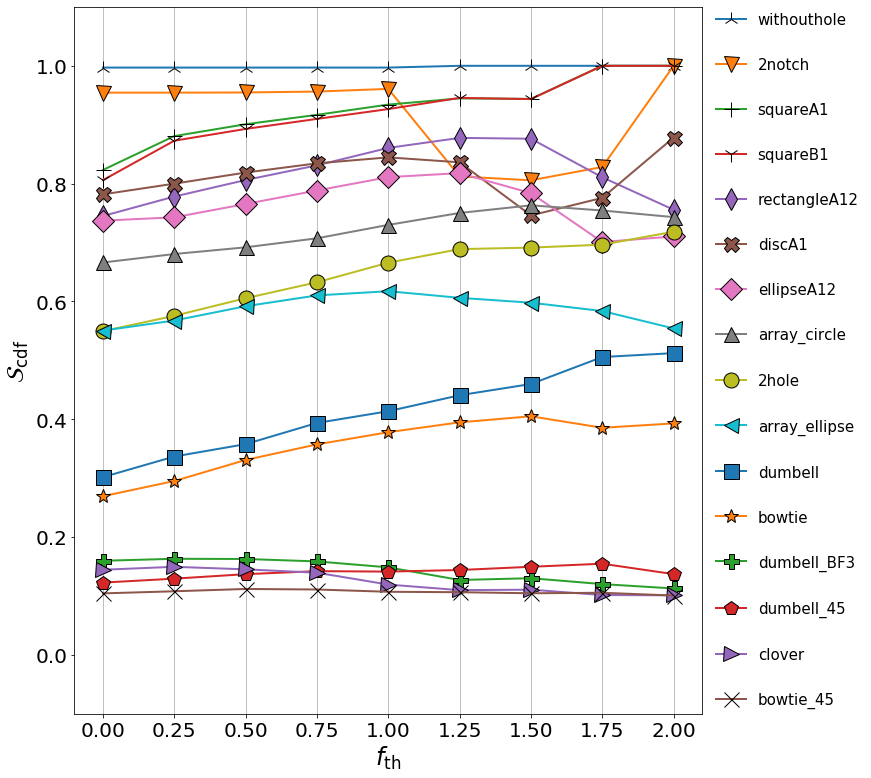

In [10]:
# Rand Gap score wrt threshold
from matplotlib.lines import Line2D
markers_list = ["o","v","^","<",">","s","p","P","*","x","X","D","d","+","1","2","3","4",0,1,2,3,4,5,6,7,8,9,10,11
]

fig = plt.figure(figsize=(15, 13))
ax = plt.subplot(1, 1, 1)
ax.set_xlim(-.1, 2.1)
ax.set_ylim(-.1, 1.1)
ax.set_xticks(np.array([0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00]))
# ax.set_yticks(np.array([-1, -0.5, 0, 0.5, 1]))
ax.set_xlabel(r'$f_{\rm{th}}$',fontsize=24)
ax.set_ylabel(r'$\mathcal{S}_{\rm{cdf}}$',fontsize=24)
ax.tick_params(which='both', labelsize=20)
# ax.ticklabel_format(scilimits=(0,0))
ax.xaxis.offsetText.set_fontsize(20)
ax.yaxis.offsetText.set_fontsize(20)
ax.grid(visible=True, which='major', axis='x')

scores = []
for i in range(len(mesh_list)):
    
    #### Meshfile ####
    meshfile = mesh_list[i]                    # with .xdmf

    # load data
    filename = './score/'+meshfile+'_score_rand.mat'
    Score_gap = loadmat(filename)['Score_gap']
    scores.append(Score_gap[0,4])

i_sort = np.argsort(scores)[::-1]  

lines = []
for im in range(len(mesh_list)):
    i = i_sort[im]
    #### Meshfile ####
    meshfile = mesh_list[i]                    # with .xdmf
    
    # load data
    filename = './score/'+meshfile+'_score_rand.mat'
    Score_gap = loadmat(filename)['Score_gap'][0]
    
    thresholds = [0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00]
    lines.append(ax.plot(thresholds,Score_gap, '-', 
                         marker=markers_list[i], markersize=15, markeredgecolor='k',
                         label=mesh_list_simple[i], linewidth=2))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width*0.75, box.height])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5),frameon=False,
          fontsize=15,ncol=1,labelspacing=2)

plt.savefig('catalogue_rand.png', dpi=96)
# ax.legend(lines,mesh_list_simple)

In [7]:
# table for Grid stress score
# sorting
scores = []
for i in range(len(mesh_list)):
    
    #### Meshfile ####
    meshfile = mesh_list[i]                    # with .xdmf
    meshpath = './output_files/'
    
    #### Evaluate strain diversity ####
    # load data
    filename = './score/'+meshfile+'_score_grid.mat'
    Score_gap = loadmat(filename)['Score_gap']
    scores.append(Score_gap[0,4])

i_sort = np.argsort(scores)  
    
print('\hline')

for im in range(len(mesh_list)):
    i = i_sort[im]
    
    #### Meshfile ####
    meshfile = mesh_list[i]                    # with .xdmf
    meshpath = './output_files/'
    
    # load data
    filename = './score/'+meshfile+'_score_grid.mat'
    Score_gap = loadmat(filename)['Score_gap'][0]
    
    line = (r'\texttt{'+re.sub('_','\_',mesh_list_simple[i])+
            r'}} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\'
            .format(Score_gap[0],Score_gap[1],Score_gap[2],
                    Score_gap[3],Score_gap[4],Score_gap[5],
                    Score_gap[6],Score_gap[7],Score_gap[8]))
#     line = (r'\texttt{'+re.sub('_','\_',mesh_list_simple[i])+
#             r'}} & {:.2f} & {:.2f} \\'
#             .format(Score_gap[0,3],Score_uniformity[0,3]))
    print(line)
    print('\hline')

\hline
\texttt{bowtie\_45} & 0.10 & 0.10 & 0.11 & 0.11 & 0.12 & 0.11 & 0.10 & 0.10 & 0.10 \\
\hline
\texttt{clover} & 0.15 & 0.16 & 0.16 & 0.15 & 0.12 & 0.10 & 0.09 & 0.07 & 0.07 \\
\hline
\texttt{dumbell\_BF3} & 0.17 & 0.17 & 0.16 & 0.16 & 0.15 & 0.13 & 0.13 & 0.12 & 0.12 \\
\hline
\texttt{dumbell\_45} & 0.13 & 0.14 & 0.14 & 0.15 & 0.15 & 0.16 & 0.16 & 0.17 & 0.18 \\
\hline
\texttt{bowtie} & 0.28 & 0.30 & 0.33 & 0.34 & 0.36 & 0.38 & 0.41 & 0.43 & 0.44 \\
\hline
\texttt{dumbell} & 0.30 & 0.34 & 0.36 & 0.38 & 0.40 & 0.43 & 0.44 & 0.47 & 0.48 \\
\hline
\texttt{array\_ellipse} & 0.58 & 0.59 & 0.61 & 0.64 & 0.64 & 0.64 & 0.61 & 0.62 & 0.63 \\
\hline
\texttt{2hole} & 0.55 & 0.59 & 0.62 & 0.66 & 0.68 & 0.68 & 0.70 & 0.73 & 0.75 \\
\hline
\texttt{array\_circle} & 0.66 & 0.67 & 0.69 & 0.70 & 0.73 & 0.74 & 0.75 & 0.78 & 0.78 \\
\hline
\texttt{ellipseA12} & 0.73 & 0.74 & 0.76 & 0.79 & 0.81 & 0.82 & 0.79 & 0.74 & 0.69 \\
\hline
\texttt{discA1} & 0.78 & 0.80 & 0.81 & 0.83 & 0.85 & 0.84 & 0.77 & 0.

In [8]:
# table for Rand stress score
# sorting
scores = []
for i in range(len(mesh_list)):
    
    #### Meshfile ####
    meshfile = mesh_list[i]                    # with .xdmf
    meshpath = './output_files/'
    
    #### Evaluate strain diversity ####
    # load data
    filename = './score/'+meshfile+'_score_rand.mat'
    Score_gap = loadmat(filename)['Score_gap']
    scores.append(Score_gap[0,4])

i_sort = np.argsort(scores)  
    
print('\hline')

for im in range(len(mesh_list)):
    i = i_sort[im]
    
    #### Meshfile ####
    meshfile = mesh_list[i]                    # with .xdmf
    meshpath = './output_files/'
    
    # load data
    filename = './score/'+meshfile+'_score_rand.mat'
    Score_gap = loadmat(filename)['Score_gap'][0]
    
    line = (r'\texttt{'+re.sub('_','\_',mesh_list_simple[i])+
            r'}} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\'
            .format(Score_gap[0],Score_gap[1],Score_gap[2],
                    Score_gap[3],Score_gap[4],Score_gap[5],
                    Score_gap[6],Score_gap[7],Score_gap[8]))
#     line = (r'\texttt{'+re.sub('_','\_',mesh_list_simple[i])+
#             r'}} & {:.2f} & {:.2f} \\'
#             .format(Score_gap[0,3],Score_uniformity[0,3]))
    print(line)
    print('\hline')

\hline
\texttt{bowtie\_45} & 0.10 & 0.11 & 0.11 & 0.11 & 0.11 & 0.11 & 0.10 & 0.11 & 0.10 \\
\hline
\texttt{clover} & 0.14 & 0.15 & 0.14 & 0.14 & 0.12 & 0.11 & 0.11 & 0.10 & 0.10 \\
\hline
\texttt{dumbell\_45} & 0.12 & 0.13 & 0.14 & 0.14 & 0.14 & 0.14 & 0.15 & 0.15 & 0.14 \\
\hline
\texttt{dumbell\_BF3} & 0.16 & 0.16 & 0.16 & 0.16 & 0.15 & 0.13 & 0.13 & 0.12 & 0.11 \\
\hline
\texttt{bowtie} & 0.27 & 0.29 & 0.33 & 0.36 & 0.38 & 0.39 & 0.40 & 0.39 & 0.39 \\
\hline
\texttt{dumbell} & 0.30 & 0.34 & 0.36 & 0.39 & 0.41 & 0.44 & 0.46 & 0.51 & 0.51 \\
\hline
\texttt{array\_ellipse} & 0.55 & 0.57 & 0.59 & 0.61 & 0.62 & 0.61 & 0.60 & 0.58 & 0.55 \\
\hline
\texttt{2hole} & 0.55 & 0.58 & 0.61 & 0.63 & 0.67 & 0.69 & 0.69 & 0.70 & 0.72 \\
\hline
\texttt{array\_circle} & 0.67 & 0.68 & 0.69 & 0.71 & 0.73 & 0.75 & 0.76 & 0.75 & 0.74 \\
\hline
\texttt{ellipseA12} & 0.74 & 0.74 & 0.77 & 0.79 & 0.81 & 0.82 & 0.78 & 0.70 & 0.71 \\
\hline
\texttt{discA1} & 0.78 & 0.80 & 0.82 & 0.83 & 0.84 & 0.84 & 0.75 & 0.